<a href="https://colab.research.google.com/github/ChristianWussow/Portfolio/blob/main/Data_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="Logo.png" width="100" align="left"/> 

# <center>Data Analytics project:</center>



Congratulations on finishing the lessons content for this second unit !

We have seen a lot of concepts in the second unit and we had the chance to test some of them. Now, we get to see how these different concepts are used to better understand our data.

## Some guidelines: 
1. To run a cell you can use the shortcut use : Shift + Enter

2. Only sections mentioned as To-Do are the places where you should put in your own code other than that we do not recommend that you change the provided code.

3. You will be graded for the visibility of your code so make sure you respect the correct indentation and that your code contains suitable variables names.

4. This notebook is designed in a sequential way so if you solve your project on different days make sure to run the previous cells before you can run the one you want.

5. Teacher assistants in the slack space remain available to answer any questions you might have.

>Best of luck ! 

## Project Sections:
In this project you will practice some of the concepts seen in the data analytics unit, you will deal with a real dataset. This dataset contains house sale prices for King County. It includes homes sold between May 2014 and May 2015.

Our goal is to analyze this dataset, clean it then create a simple linear regression model using it.

This project is devided into n sections : 
1. [Setting the environement](#set_env)

2. [Importing necessary tools](#importing)

3. [Dataset discovery](#dataset_discovery)

4. [NA handling](#na_handling)

5. [Useless variables deletion](#useless_var)

6. [Outliers detection](#outliers)

7. [Feature selection](#feature_selection)

8. [Linear regression](#linear_reg)

### 1. Setting the environement:  <a id='set_env'></a>

In [ ]:
# Make sure you have virtualenv installed 
!pip install --user virtualenv

In [ ]:
'''
 To-Do: create a virtual environement called data_analytics
python3 -m venv data_analytics
.\data_analytics\Scripts\activate
'''

'\n To-Do: create a virtual environement called data_analytics\npython3 -m venv data_analytics\n.\\data_analytics\\Scripts\x07ctivate\n'

In [ ]:
# Activate the environement for windows
!source data_analytics/bin/activate

Der Befehl "source" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [ ]:
# Activate the environement for linux (debian based)
!. data_analytics/bin/activate

### 2. Importing necessary tools:<a id='importing'></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy as scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import shap

### 3. Dataset discovery:<a id='dataset_discovery'></a>

In [ ]:
# To-Do: Read the file ("kc_house_data.csv") using pandas and store in a dataframe called df

# To-Do: Print the dataframe's shape
df = pd.read_csv('G:/Meine Ablage/Phyton\Project/Project_2/Unit2-Project/kc_house_data.csv')
df.shape

(21613, 21)

In [ ]:
# To-Do: Print the dataframe's info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21606 non-null  object 
 2   price          21608 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21612 non-null  float64
 6   sqft_lot       21612 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21609 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21611 non-null  float64
 15  yr_renovated   21612 non-null  float64
 16  zipcode        21611 non-null  float64
 17  lat            21612 non-null  float64
 18  long  

### 4. NA handling:<a id='na_handling'></a>
It is clear after printing the dataset info that there are some variables that have less entries than the number of rows which means that some of them don't have values in certain rows.

Given the number of the na values, what do you think is the best method to deal with them?

In [ ]:
# To-Do: deal with the NAs in your dataset 
df.isnull().sum()

id               0
date             7
price            5
bedrooms         0
bathrooms        0
sqft_living      1
sqft_lot         1
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       4
sqft_basement    0
yr_built         2
yr_renovated     1
zipcode          2
lat              1
long             0
sqft_living15    1
sqft_lot15       0
dtype: int64

In [ ]:
df.dropna(subset=['sqft_living', 'sqft_lot', 'yr_renovated', 'sqft_living15', 'lat', 'yr_built', 'zipcode'], inplace=True)

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date'].nunique()
df['date'].value_counts().head()

2014-06-23    142
2014-06-26    131
2014-06-25    131
2015-04-27    126
2014-07-08    126
Name: date, dtype: int64

In [ ]:
df['date'] = df['date'].fillna(value = df['date'].mode()[0])
df['price'] = df['price'].fillna(value = df['price'].median())
df['sqft_above'] = df['sqft_above'].fillna(value = df['sqft_above'].median())
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### 5. Useless variables deletion:<a id='useless_var'></a>
We want to eventually do a regression on it so naturally some variables bring no added value and can be delted without impacting the results.

Delete the column that correspond to variables that aren't needed.

In [ ]:
# To-Do: delete the values of the variables that are useless
df.drop(['id', 'date'], inplace = True ,axis = 1)


### A wild playground appears !!
In the next cell, go wild with the dataset discovery.
You can calculate the mean, the median or do anything you want to learn more the data.

<b>Pro tip :</b> 
Sometimes you might want to know how many unique variables a column has, to do so you can use the padas function :

<center>pd.unique(df['column_name'])</center>

In [ ]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159900e+04,21604.000000,21604.000000,21604.000000,2.160400e+04,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21600.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000
mean,5.401278e+05,3.370765,2.114597,2079.914507,1.510878e+04,1.494330,0.007545,0.234216,3.409461,7.656915,1788.463796,291.464775,1971.003240,84.437419,98077.938206,47.560055,-122.213881,1986.520644,12767.516756
std,3.670839e+05,0.929894,0.769987,918.411812,4.142878e+04,0.540005,0.086535,0.766036,0.650806,1.175461,828.173903,442.556510,29.373968,401.759208,53.498687,0.138559,0.140848,685.356289,27306.704373
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219750e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470975,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.617500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068725e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

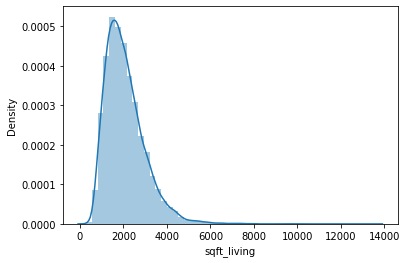

In [ ]:
# To-Do : get to know more your data WITHOUT modifying it !!

sns.distplot(df["sqft_living"])



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<AxesSubplot:xlabel='yr_renovated', ylabel='Density'>

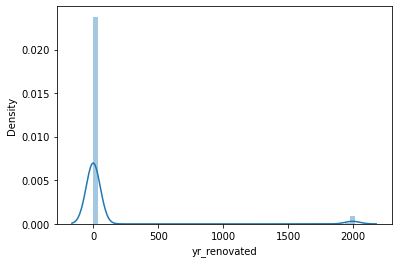

In [ ]:
sns.distplot(df["yr_renovated"])

C:\Users\chris\AppData\Local\Temp\ipykernel_5460\50337492.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["price"])


<AxesSubplot:xlabel='price', ylabel='Density'>

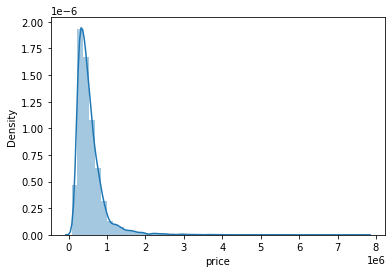

In [ ]:
sns.distplot(df["price"])

In [ ]:
df.condition.value_counts()

3    14025
4     5676
5     1701
2      172
1       30
Name: condition, dtype: int64

<AxesSubplot:xlabel='condition'>

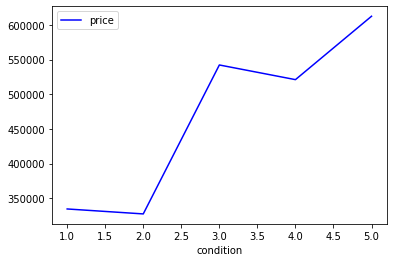

In [ ]:
df.price.groupby(df.condition).mean().plot(kind = 'line', color= 'blue', legend=True)

<AxesSubplot:xlabel='yr_built'>

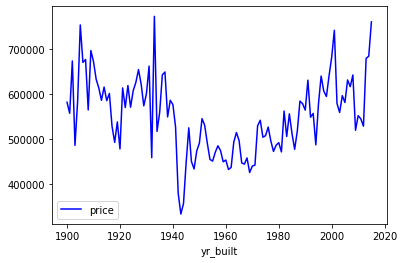

In [ ]:
df.price.groupby(df.yr_built).mean().plot(kind = 'line', color= 'blue', legend=True)

In [ ]:
df.zipcode.value_counts()

98103.0    602
98038.0    590
98115.0    583
98052.0    574
98117.0    553
          ... 
98102.0    105
98010.0    100
98024.0     81
98148.0     57
98039.0     50
Name: zipcode, Length: 70, dtype: int64

<AxesSubplot:xlabel='zipcode'>

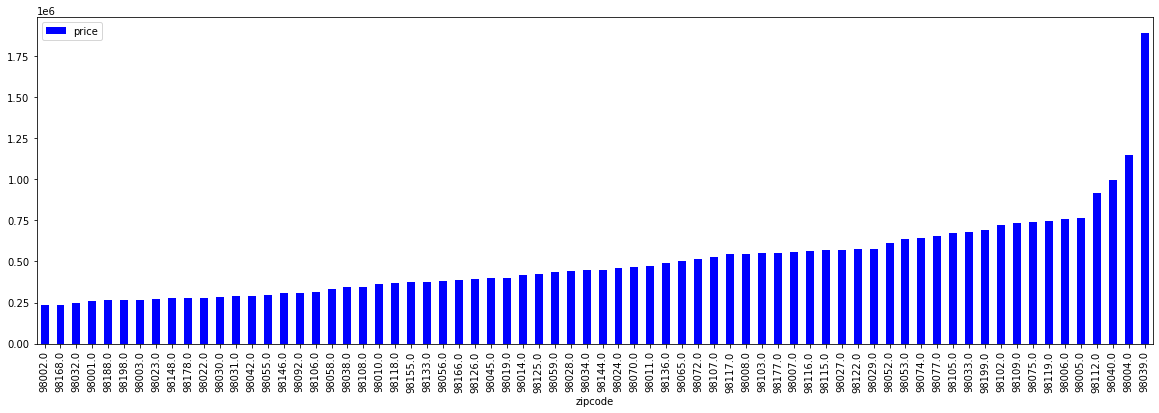

In [ ]:
df.price.groupby(df.zipcode).median().sort_values().plot(kind = 'bar', color= 'blue', legend=True, figsize=(20,6))

In [ ]:

# we ordinal ecode the zipcode column into 6 groups in respect to the median house price of each zip code

zip = pd.DataFrame(df.price.groupby(df.zipcode).median().sort_values().reset_index())

zip_list = list(zip.iloc[:,0])

df['zipcode'] = df.zipcode.apply(lambda x: 6 if x == zip_list[-1] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 5 if x in zip_list[-4:-1] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 4 if x in zip_list[-13:-4] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 3 if x in zip_list[-33:-13] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 2 if x in zip_list[-50:-33] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 1 if x in zip_list[:-50] else x)
df['zipcode'].value_counts()

3.0    6812
1.0    6064
2.0    5411
4.0    2400
5.0     867
6.0      50
Name: zipcode, dtype: int64

<AxesSubplot:xlabel='floors'>

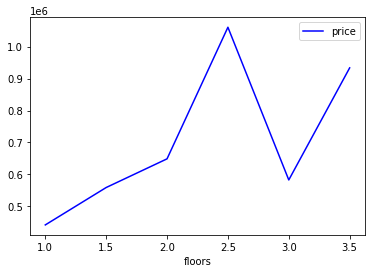

In [ ]:
df.price.groupby(df.floors).mean().plot(kind = 'line', color= 'blue', legend=True)

<AxesSubplot:xlabel='bedrooms'>

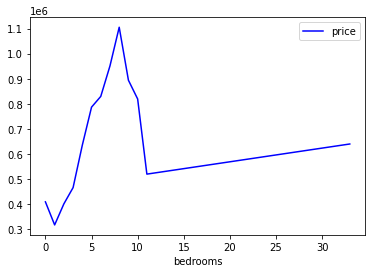

In [ ]:
df.price.groupby(df.bedrooms).mean().plot(kind = 'line', color= 'blue', legend=True)

30

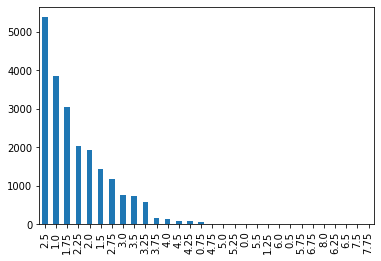

In [ ]:
df.bathrooms.value_counts().plot(kind='bar')
df.bathrooms.nunique()

<AxesSubplot:xlabel='bathrooms'>

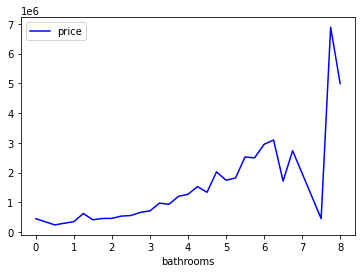

In [ ]:

df.price.groupby(df.bathrooms).mean().plot(kind = 'line', color= 'blue', legend=True)


<AxesSubplot:>

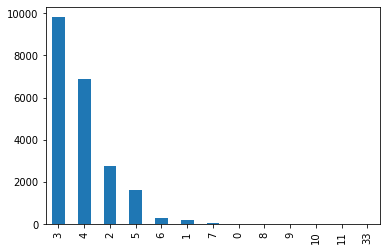

In [ ]:
df.bedrooms.value_counts().plot(kind = 'bar')


<AxesSubplot:xlabel='waterfront'>

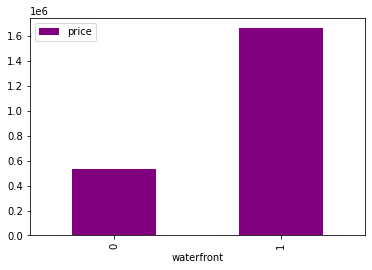

In [ ]:

df.price.groupby(df.waterfront).mean().plot(kind = 'bar', color= 'purple', legend=True)


<AxesSubplot:xlabel='view'>

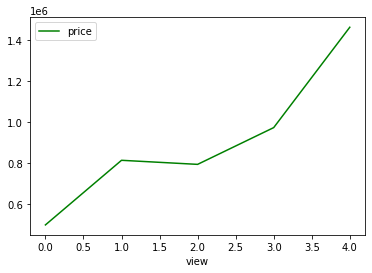

In [ ]:
df.price.groupby(df.view).mean().plot(color= 'green', legend=True)

<AxesSubplot:xlabel='condition'>

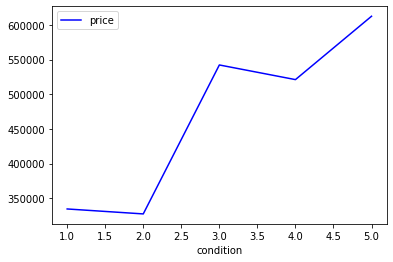

In [ ]:
df.price.groupby(df.condition).mean().plot(color= 'blue', legend=True)

<AxesSubplot:>

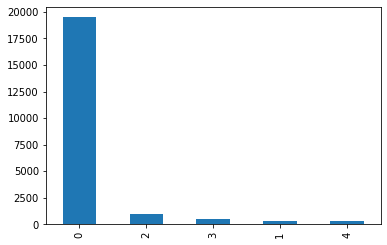

In [ ]:
df.view.value_counts().plot(kind= 'bar')

<AxesSubplot:xlabel='view'>

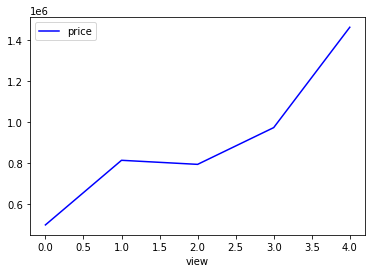

In [ ]:
df.price.groupby(df.view).mean().plot(color= 'blue', legend=True)

<AxesSubplot:>

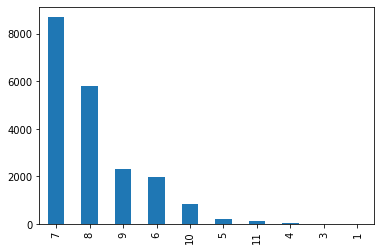

In [ ]:
df.grade.value_counts().plot(kind= 'bar')

<AxesSubplot:xlabel='grade'>

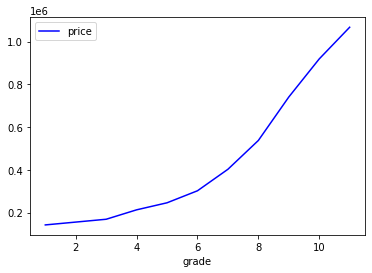

In [ ]:
df.price.groupby(df.grade).mean().plot(kind = 'line', color= 'blue', legend=True)

<AxesSubplot:xlabel='lat', ylabel='price'>

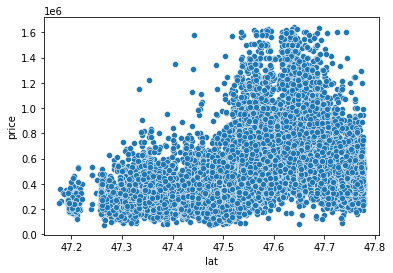

In [ ]:
sns.scatterplot(data=df, x="lat", y="price")

In [ ]:
df.yr_renovated.value_counts()

0.0       20690
2014.0       91
2013.0       37
2003.0       36
2005.0       35
          ...  
1951.0        1
1959.0        1
1948.0        1
1954.0        1
1944.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [ ]:
# we have continuous, binary and oridinal features
# the data is often times very skewed

### 6.Outliers detection:<a id='outliers'></a>
Having outliers is a common problem that might affect the quality of the model that we're building.

Let's assume that we're not interested in very expensive or very cheap houses, we want a model that best fits the average priced houses.

To create such a model, we detect outliers and delete them using the Z-score method seen in the lessons.

In [ ]:
# To-Do : detect the outliers then delete them ad delete the column created to calculate the Z-score
# calculte z-score for continuous variables --> we assign binary and ordinal varibales to cols

from scipy import stats
cols = ['waterfront', 'yr_renovated','view', 'condition', 'bedrooms', 'zipcode', 'lat', 'grade']
df_z = df.copy()
df_z = df_z[[i for i in list(df_z.columns) if i not in cols]]

for i in list(df_z.columns):
  df_z[i + '_zscore'] = stats.zscore(df_z[i])

In [ ]:
df_z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21604 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 21604 non-null  float64
 1   bathrooms             21604 non-null  float64
 2   sqft_living           21604 non-null  float64
 3   sqft_lot              21604 non-null  float64
 4   floors                21604 non-null  float64
 5   grade                 21604 non-null  int64  
 6   sqft_above            21604 non-null  float64
 7   sqft_basement         21604 non-null  int64  
 8   yr_built              21604 non-null  float64
 9   long                  21604 non-null  float64
 10  sqft_living15         21604 non-null  float64
 11  sqft_lot15            21604 non-null  int64  
 12  price_zscore          21604 non-null  float64
 13  bathrooms_zscore      21604 non-null  float64
 14  sqft_living_zscore    21604 non-null  float64
 15  sqft_lot_zscore    

In [ ]:
# for some columns we stats.zscore method didn't work so we calculte the z-score manually

df_z['sqft_living_zscore'] = (df['sqft_living'] - df['sqft_living'].mean()) / df['sqft_living'].std()

df_z['price_zscore'] = (df['price'] - df['price'].mean()) / df['price'].std()

df_z['sqft_above_zscore'] = (df['sqft_above'] - df['sqft_above'].mean()) / df['sqft_above'].std()



In [ ]:
df_z['price_zscore'].describe()


count    2.159900e+04
mean    -1.473786e-16
std      1.000000e+00
min     -1.267089e+00
25%     -5.942861e-01
50%     -2.455238e-01
75%      2.856899e-01
max      1.950473e+01
Name: price_zscore, dtype: float64

In [ ]:
# we exclude all rows with outliers --> - 3 < z > 3

for i in list(df.columns):
 if i not in cols:
  df = df[abs(df_z[i + '_zscore'] < 3)]
df.head()



Boolean Series key will be reindexed to match DataFrame index.


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180.0,5650.0,1.0,0,0,3,7,1180.0,0,1955.0,0.0,1.0,47.5112,-122.257,1340.0,5650
1,538000.0,3,2.25,2570.0,7242.0,2.0,0,0,3,7,2170.0,400,1951.0,1991.0,2.0,47.7210,-122.319,1690.0,7639
2,180000.0,2,1.00,770.0,10000.0,1.0,0,0,3,6,770.0,0,1933.0,0.0,2.0,47.7379,-122.233,2720.0,8062
3,604000.0,4,3.00,1960.0,5000.0,1.0,0,0,5,7,1050.0,910,1965.0,0.0,3.0,47.5208,-122.393,1360.0,5000
4,510000.0,3,2.00,1680.0,8080.0,1.0,0,0,3,8,1680.0,0,1987.0,0.0,3.0,47.6168,-122.045,1800.0,7503


In [ ]:
# we can see a reduction in rows

print(df.shape)
print(df_z.shape)

(20067, 19)
(21604, 22)


### 7.Feature selection:<a id='feature_selection'></a>
It is clear that even after deleting some features, there might be other features that aren't obviously useless but can be delted and keep a good overall performance.

To verify this, we perform feature selection on our variables.

<AxesSubplot:>

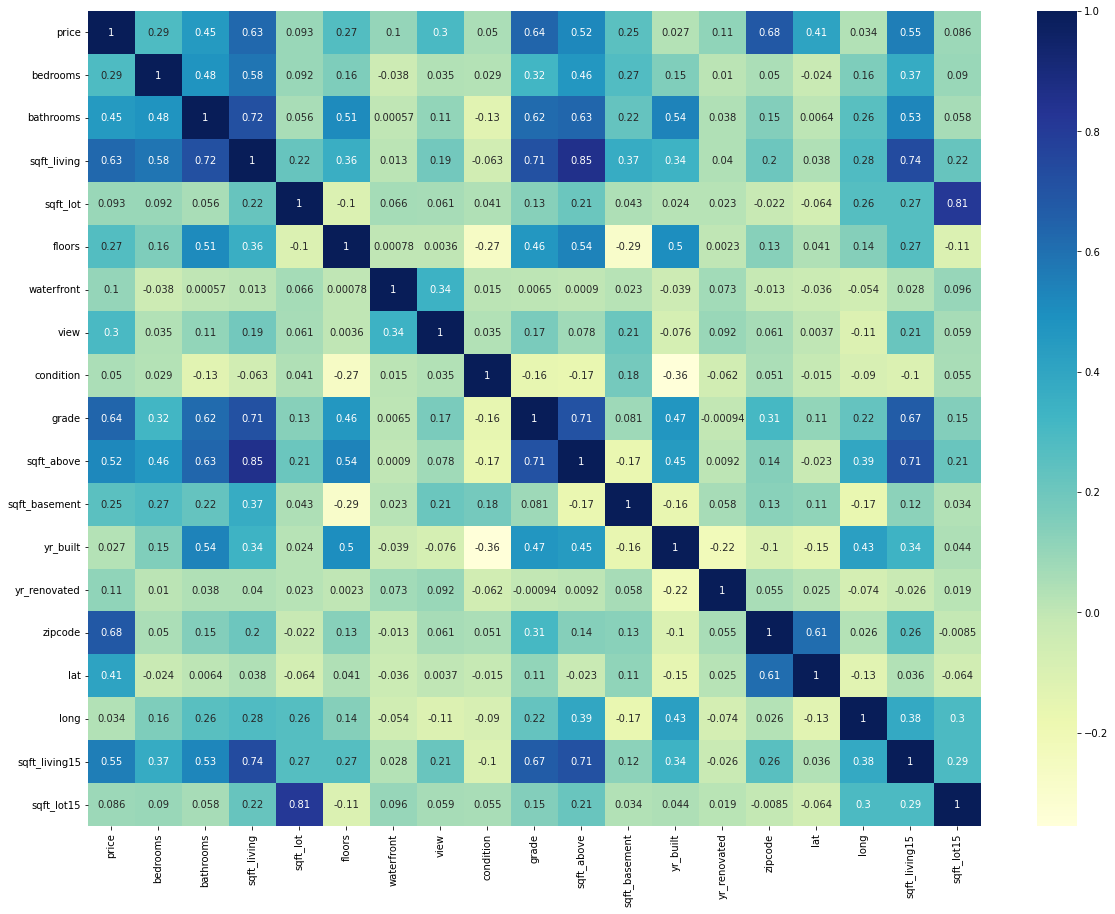

In [ ]:
# To-Do : perform feature selection using correlation
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


In [ ]:
# we only want to work with variables with a corr > 0.1 and also add ordinal variable 'condition' for later one hot encoding

col = [i for i in list(df.columns) if df[i].corr(df['price']) > 0.1]
df = df[col + ['condition']]
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated',
       'zipcode', 'lat', 'sqft_living15', 'condition'],
      dtype='object')

## Correlation

<AxesSubplot:>

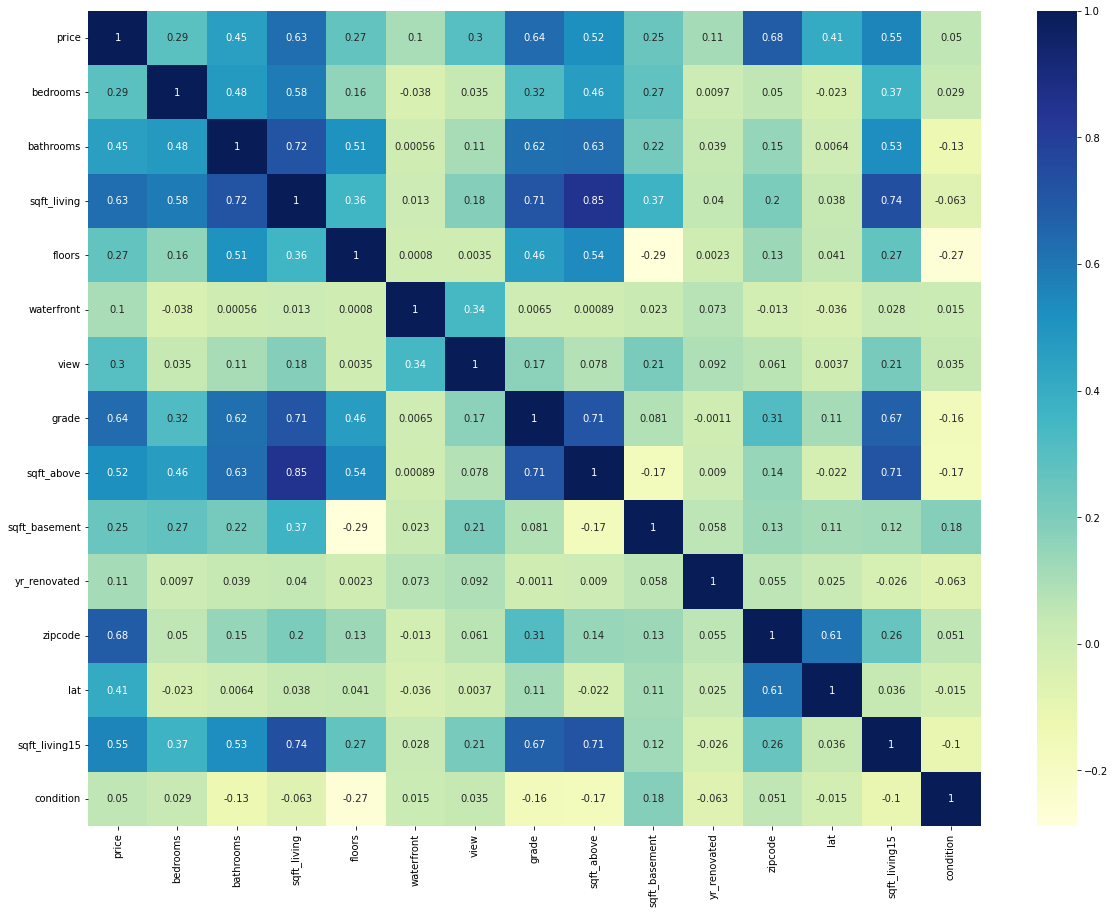

In [ ]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [ ]:
# To-Do : drop the variables that seem highly correlated to you
# we drop 'sqft_above', 'sqft_living15' as the are highly correlated with 'sqft_living'

df.drop(['sqft_above', 'sqft_living15'], axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20076 entries, 0 to 21612
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20076 non-null  float64
 1   bedrooms       20076 non-null  int64  
 2   bathrooms      20076 non-null  float64
 3   sqft_living    20076 non-null  float64
 4   floors         20076 non-null  float64
 5   waterfront     20076 non-null  int64  
 6   view           20076 non-null  int64  
 7   grade          20076 non-null  int64  
 8   sqft_basement  20076 non-null  int64  
 9   yr_renovated   20076 non-null  float64
 10  zipcode        20076 non-null  float64
 11  lat            20076 non-null  float64
 12  condition      20076 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 2.1 MB


### Train Test Split

In [ ]:
x = df.loc[:,df.columns != 'price']

y = df['price']

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3)

### OneHotEncoding and Scaling

In [ ]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# we want to standardize continuous features and one hot encode binary and ordinal features so we separate the columns

columns_to_encode = ['view','waterfront','condition', 'zipcode']
columns_to_scale  = [i for i in x_train.columns if i not in columns_to_encode]

s = StandardScaler()
o = OneHotEncoder(sparse=False)


scaled_columns_train  = pd.DataFrame(s.fit_transform(x_train[columns_to_scale]), columns= [columns_to_scale]) 

encoded_columns_train =  pd.DataFrame(o.fit_transform(x_train[columns_to_encode]))


scaled_columns_test  = pd.DataFrame(s.transform(x_test[columns_to_scale]), columns= [columns_to_scale]) 

encoded_columns_test =  pd.DataFrame(o.transform(x_test[columns_to_encode]))



complete_cols = columns_to_scale + list(o.get_feature_names_out(columns_to_encode))

# we concantenate the transformned columns

processed_data_train = pd.DataFrame(np.concatenate([scaled_columns_train, encoded_columns_train], axis=1), columns = complete_cols)

processed_data_test = pd.DataFrame(np.concatenate([scaled_columns_test, encoded_columns_test], axis=1), columns = complete_cols)



x_train = processed_data_train

x_test = processed_data_test

### 8.Linear regression:<a id='linear_reg'></a>
Now that our data is clean and ready to be used, let's try to fit it into a linear regression model.

<ul>
    <li>We begin by splitting our variables into dependant and independant variables.</li>
    <li>We create the model using the LinearRegression class.</li>
    <li>We evaluate our model using the R² score</li>
</ul>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
# ordinary LR

lr = LinearRegression(fit_intercept=False).fit(x_train, y_train)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("MSE: ", round(mean_squared_error(y_test, y_pred),2))
print('R squared training set: ', round(lr.score(x_train, y_train)*100, 2))
print('R squared test set: ', round(lr.score(x_test, y_test)*100, 2))

MSE:  13512856591.5
R squared training set:  78.93
R squared test set:  78.37


In [ ]:
# polynomial linear regression --> overfitting

poly_reg_n=PolynomialFeatures(degree=2)
x_poly_train=poly_reg_n.fit_transform(x_train)
x_poly_test=poly_reg_n.transform(x_test)
poly_reg_n.fit(x_poly_train,y_train)
lrn=LinearRegression(fit_intercept=False)
lrn.fit(x_poly_train,y_train)
y_pred = lrn.predict(x_poly_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("Poly R2 Train: ", round(lrn.score(x_poly_train, y_train)*100, 2))
print("Poly R2 Test: ", round(lrn.score(x_poly_test, y_test)*100, 2))

MSE:  1.0586681487518526e+28
Poly R2 Train:  83.7
Poly R2 Test:  -1.694303352222253e+19


In [ ]:
# Lsso LR

reg = Lasso(alpha=1, fit_intercept = False, max_iter=5000)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("MSE: ", round(mean_squared_error(y_test, y_pred),2))
print('Lasso R squared training set: ', round(reg.score(x_train, y_train)*100, 2))
print('Lasso R squared test set: ', round(reg.score(x_test, y_test)*100, 2))


MSE:  13510130389.14
Lasso R squared training set:  78.93
Lasso R squared test set:  78.38


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+13, tolerance: 4.256e+11


In [ ]:
# Ridge LR

reg = Ridge(alpha=1, fit_intercept=False)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print('Ridge R squared training set: ', round(reg.score(x_train, y_train)*100, 2))
print('Ridge R squared test set: ', round(reg.score(x_test, y_test)*100, 2))

MSE:  13530220263.014345
Ridge R squared training set:  78.93
Ridge R squared test set:  78.35


In [ ]:
# Lasso LR with Polynomial Degrees of 2

poly_reg_2=PolynomialFeatures(degree=2)
x_poly_train=poly_reg_2.fit_transform(x_train)
x_poly_test=poly_reg_2.transform(x_test)
poly_reg_2.fit(x_poly_train,y_train)
lr4=Lasso(alpha= 6, fit_intercept=False)
lr4.fit(x_poly_train,y_train)
y_pred = lr4.predict(x_poly_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("Lasso R2 Train: ", round(lr4.score(x_poly_train, y_train)*100, 2))
print("Lasso R2 Test: ", round(lr4.score(x_poly_test, y_test)*100, 2))

MSE:  10814782479.113146
Lasso R2 Train:  83.64
Lasso R2 Test:  81.81


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.778e+13, tolerance: 4.302e+11


In [ ]:
# best result on test set with Ridge LR with Polynomial Degrees of 2

poly_reg_2=PolynomialFeatures(degree=2)
x_poly_train=poly_reg_2.fit_transform(x_train)
x_poly_test=poly_reg_2.transform(x_test)
poly_reg_2.fit(x_poly_train,y_train)
lr4=Ridge(alpha= 7, fit_intercept=False)
lr4.fit(x_poly_train,y_train)
y_pred = lr4.predict(x_poly_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("Ridge R2 Train: ", round(lr4.score(x_poly_train, y_train)*100, 2))
print("Ridge R2 Test: ", round(lr4.score(x_poly_test, y_test)*100, 2))

MSE:  11227112452.189503
Ridge R2 Train:  83.61
Ridge R2 Test:  82.03


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
import keras
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

early_stopping.monitor='val_loss'
early_stopping.patience = 10

In [ ]:
model=Sequential([
    Dense(units = 32, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dense(units = 64, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dense(units = 128, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dropout(0.3),
    Dense(units = 64, activation = 'LeakyReLU', kernel_initializer='he_normal',kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dropout(0.3),
    Dense(units = 32, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dense(units = 1, activation = 'LeakyReLU', kernel_initializer='he_normal')    
])

In [ ]:
model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.01), metrics = ['mse'])
        
model_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 50, verbose=1, callbacks=[early_stopping])

Epoch 1/50
440/440 [==============================] - 4s 3ms/step - loss: 298174873600.0000 - mse: 298174873600.0000 - val_loss: 300923387904.0000 - val_mse: 300923387904.0000
Epoch 2/50
440/440 [==============================] - 1s 3ms/step - loss: 292155129856.0000 - mse: 292155129856.0000 - val_loss: 289028210688.0000 - val_mse: 289028210688.0000
Epoch 3/50
440/440 [==============================] - 1s 2ms/step - loss: 283039662080.0000 - mse: 283039662080.0000 - val_loss: 283634204672.0000 - val_mse: 283634204672.0000
Epoch 4/50
440/440 [==============================] - 1s 2ms/step - loss: 271190441984.0000 - mse: 271190441984.0000 - val_loss: 268126355456.0000 - val_mse: 268126355456.0000
Epoch 5/50
440/440 [==============================] - 1s 2ms/step - loss: 257051279360.0000 - mse: 257051279360.0000 - val_loss: 256236322816.0000 - val_mse: 256236322816.0000
Epoch 6/50
440/440 [==============================] - 1s 2ms/step - loss: 241229381632.0000 - mse: 241229381632.0000 - v

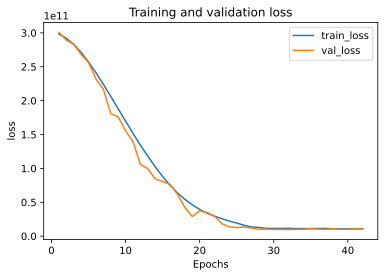

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(model_history, 'loss')

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
y_pred = model.predict(x_test)

y_pred =y_pred[:,0]
y_pred =y_pred
y_pred.shape
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)
y_pred=tf.convert_to_tensor(y_pred,dtype=tf.float64)


print(coeff_determination(y_test,y_pred))

189/189 [==============================] - 0s 954us/step
tf.Tensor(0.8343251138010263, shape=(), dtype=float64)


## SHAP

In [ ]:
explainer = shap.explainers.Linear(lr,x_train)
shap_values = explainer.shap_values(x_train)

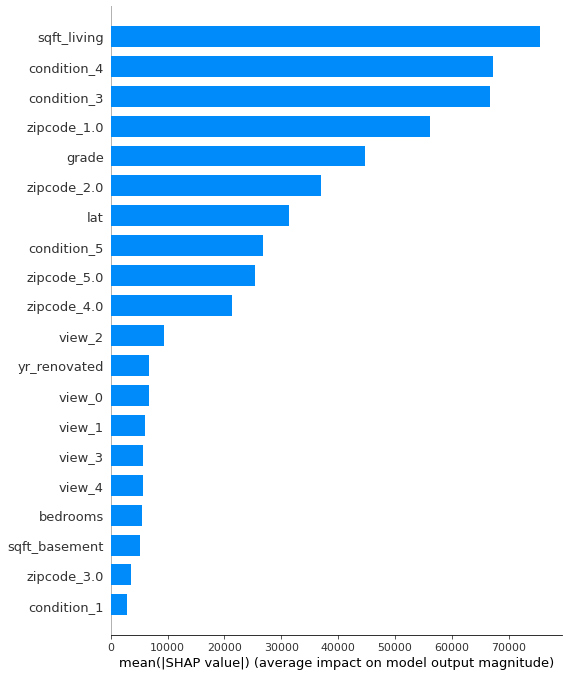

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type='bar')

## Conclusion:
Data preparation is a very important step in the machine learning pipeline. It is crucial to clean our data and understand it very well before we can create any model on the data.

In this notebook, we have spent 4 steps preparing our data but only 1 to create the model. This reflects how time consuming the process of data preparation is compared to the other steps as well as the importance of the quality of the data used.

In the next unit, we will see more about the models creation process and see a lot of important concepts in depth.